In [52]:
import sys
sys.path.append('../code/functions')
from connectLib import otsuVox
from connectLib import clusterThresh
from plosLib import pipeline as PLOS
from random import randrange as rand
from cluster import Cluster
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 1. Pseudocode
![Neighborhood Density Filter Pseudocode](neighborhoodDensityPseudo.jpg)

# 2. Algorithm Code

In [2]:
def neighborhoodDensity(data, interPlane = 1, intraPlane = 1, percentile = 50):
    output = np.zeros_like(data)
    for z in range(data.shape[0]):
        for y in range(data.shape[1]):
            for x in range(data.shape[2]):
                zLow = z-intraPlane
                zHigh = z+intraPlane
                yLow = y-interPlane
                yHigh = y+interPlane
                xLow = x-interPlane
                xHigh = x+interPlane
                if zLow>=0 and zHigh<data.shape[0] and yLow>=0 and yHigh<data.shape[1] and xLow>=0 and xHigh<data.shape[2]:
                    subVol = data[zLow:zHigh, yLow:yHigh, xLow:xHigh]
                    if not all(subVol.shape) == 0:
                        thresh = np.percentile(subVol, percentile)
                        binSubVol = subVol >= thresh
                        output[z][y][x] = (np.count_nonzero(binSubVol)/float(interPlane*interPlane*intraPlane)) * data[z][y][x] * np.average(subVol)
    return output

# 3. Predicted Performance Conditions
I believe that this algorithm will perform well under conditions where the data we wish to extract is surrounded by other data that we wish to extract, and when noise is surrounded by other pixels that can be identified as background

In other words, the alorithm will work well when the distribution of pixel intensities around true data points is skewed left, and the distribution of pixel intensities around noise is skiewed right

# 4. Simulation Data
## Easy Sim
This sim data will show a clearly bimodal image with a grid of outliers distributed over it. These outliers will be of an intensity such that they may resonably be classified as noise or synapse, depending on the area they occur in.

The goal of both PLOS and the Nieghborhood Filter in this sim will be to remove the obvious noise outliers wile not punishing the outliers that may be considered synapse

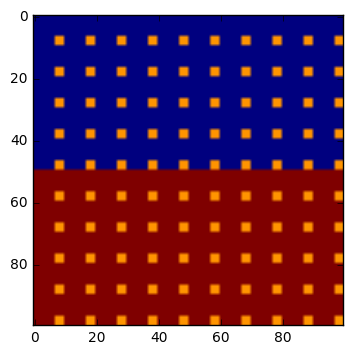

In [3]:
#generating easy sim data

easySim = np.zeros((100, 100, 100))
for z in range(100):
    for y in range(50, 100):
        for x in range(100):
            easySim[z][y][x] = 100

for y in range(0, 100, 10):
    for z in range(100):
        for x in range(0, 100, 10):
            for i in range(3):
                for j in range(3):
                    try:
                        easySim[z][y-3+i][x-3+j] = 75
                    except:
                        continue
        
plt.figure()
plt.imshow(easySim[50])
plt.show()

In [4]:
easySimN = neighborhoodDensity(easySim, 6, 6, 50)

In [5]:
easySimP = PLOS(easySim, 1, 1)

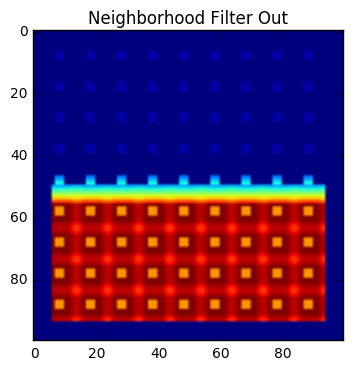

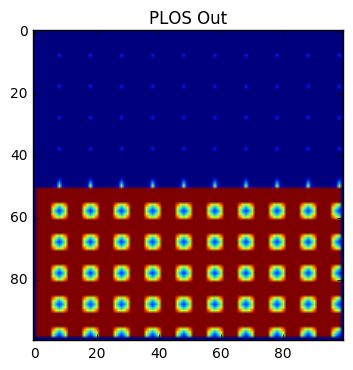

In [6]:
plt.figure()
plt.title('Neighborhood Filter Out')
plt.imshow(easySimN[50])
plt.show()

plt.figure()
plt.title('PLOS Out')
plt.imshow(easySimP[50])
plt.show()

In [7]:
easySimNB = otsuVox(easySimN)
easySimPB = otsuVox(easySimP)

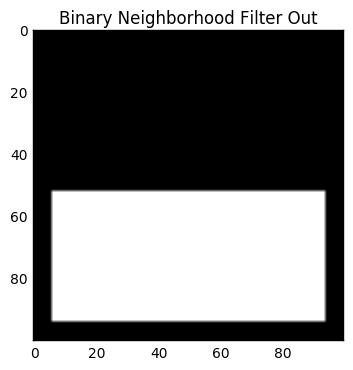

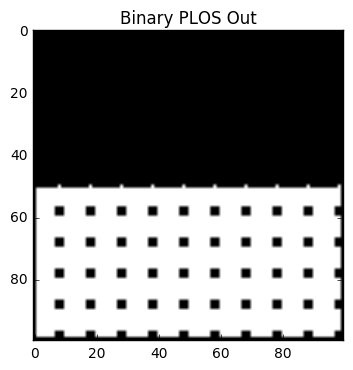

In [8]:
plt.figure()
plt.title('Binary Neighborhood Filter Out')
plt.imshow(easySimNB[50], cmap='gray')
plt.show()

plt.figure()
plt.title('Binary PLOS Out')
plt.imshow(easySimPB[50], cmap='gray')
plt.show()

## Easy Sim Analysis
As you can see above, the PLOS pipeline heavily punishes the outliers both the synapse region and in the non synapse region. This is not an effective strategy for our data since synapses in the foreground region may have a value identical to that of noise in the non foreground region.

The neighborhood filter mitigates this issue by only removing the outliers in the noise region, while leaving the foreground region entirely intact.

## Realistic Sim
The realistic simulation will be run on data that models the distribution of synapses and noise in our true data

In [39]:
def generatePointSet():
    center = (rand(0, 9), rand(0, 999), rand(0, 999))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 1000:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(rand(1000, 2000)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

## Scoring Code
The following code was lifted from the precisionrecall notebook and calculates f1 score, among other stats

In [58]:
def f1score(trueClusterList, testClusterList):
    
    tp = 0
    fp = 0
    fn = 0
    
    testClusterTuples = []
    for elem in testClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        testClusterTuples.append(myTupleList)

    trueClusterTuples = []
    for elem in trueClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        trueClusterTuples.append(myTupleList)
    
    truePositives = []
    for testList in testClusterTuples:
        found = False
        for trueList in trueClusterTuples:
            if len(set(testList).intersection(set(trueList))) > 0:
                found = True
        if found:
            truePositives.append(testList)
            tp+=1
    
    fp = len(testClusterList) - tp
    fn = len(trueClusterList) - tp
    precision = float(tp)/float(fp+tp)
    recall = float(tp)/float(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1, truePositives, trueClusterTuples, testClusterTuples

In [41]:
testVol, noiseVol = generateTestVolume()

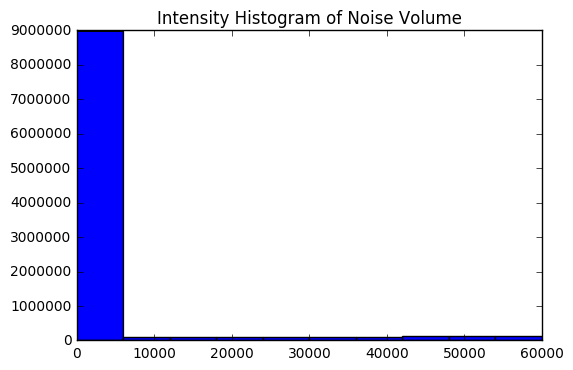

In [42]:
plt.figure()
plt.hist(noiseVol.flatten())
plt.title("Intensity Histogram of Noise Volume")
plt.show()

In [101]:
realSimN = neighborhoodDensity(noiseVol, 2, 2, 50)

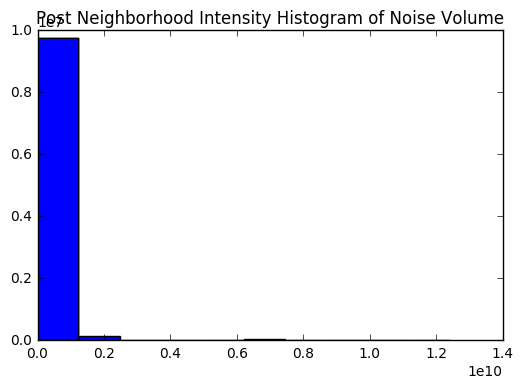

In [102]:
plt.figure()
plt.hist(realSimN.flatten())
plt.title("Post Neighborhood Intensity Histogram of Noise Volume")
plt.show()

In [103]:
realSimNB = otsuVox(realSimN)

In [104]:
realSimP = PLOS(noiseVol, 1, 1)

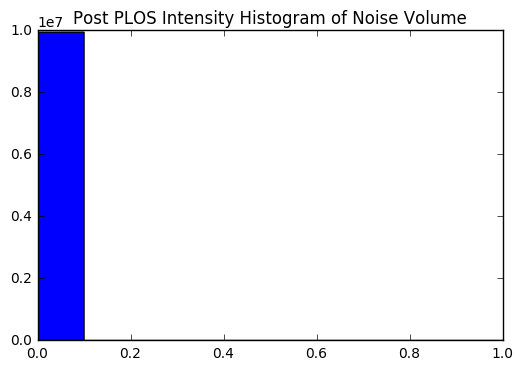

In [105]:
plt.figure()
plt.hist(realSimP.flatten())
plt.title("Post PLOS Intensity Histogram of Noise Volume")
plt.show()

In [106]:
realSimPB = otsuVox(realSimP)

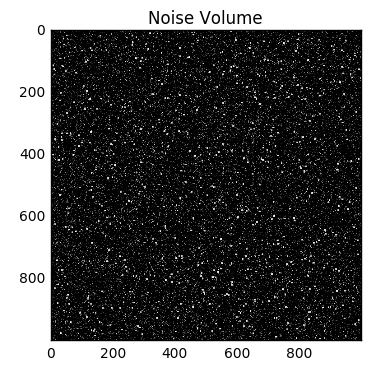

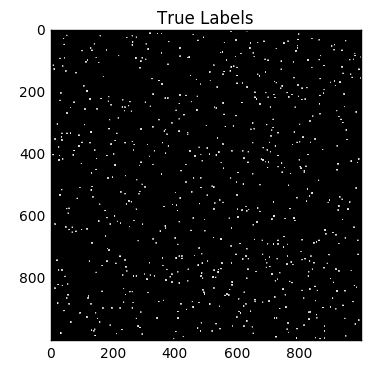

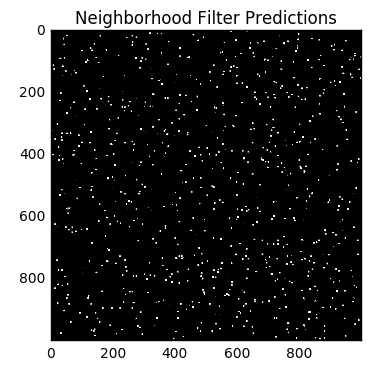

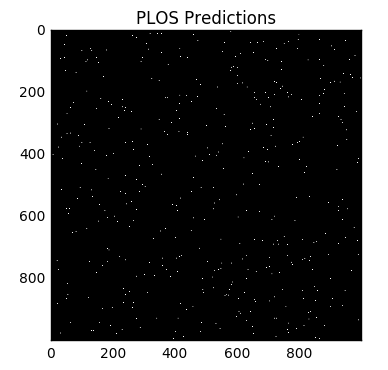

In [107]:
plt.figure()
plt.title('Noise Volume')
plt.imshow(noiseVol[5], cmap='gray')
plt.show()

plt.figure()
plt.imshow(testVol[5], cmap='gray')
plt.title('True Labels')
plt.show()

plt.figure()
plt.imshow(realSimNB[5], cmap='gray')
plt.title('Neighborhood Filter Predictions')
plt.show()

plt.figure()
plt.imshow(realSimPB[5], cmap='gray')
plt.title('PLOS Predictions')
plt.show()

In [108]:
clustersN = clusterThresh(realSimNB[4:6])
clustersP = clusterThresh(realSimPB[4:6])
clustersT = clusterThresh(testVol[4:6])

In [109]:
precisionN, recallN, f1N, _, _, _ = f1score(clustersT, clustersN)
precisionP, recallP, f1P, _, _, _ = f1score(clustersT, clustersP)
print 'Neighborhood:'
print '\tPrecision: ', precisionN
print '\tRecall: ', recallN
print '\tf1: ', f1N

print 'PLOS:'
print '\tPrecision: ', precisionP
print '\tRecall: ', recallP
print '\tf1: ', f1P

Neighborhood:
	Precision:  0.471428571429
	Recall:  0.988023952096
	f1:  0.63829787234
PLOS:
	Precision:  1.0
	Recall:  0.68502994012
	f1:  0.813077469794


In [110]:
statListP = []
statListN = []

def executeRealisticSim():
    testVol, noiseVol = generateTestVolume()
    
    realSimN = neighborhoodDensity(noiseVol, 2, 2, 50)
    realSimNB = otsuVox(realSimN)
    realSimP = PLOS(noiseVol, 1, 1)
    realSimPB = otsuVox(realSimP)
    
    clustersN = clusterThresh(realSimNB[4:6])
    clustersP = clusterThresh(realSimPB[4:6])
    clustersT = clusterThresh(testVol[4:6])
    
    precisionN, recallN, f1N, _, _, _ = f1score(clustersT, clustersN)
    precisionP, recallP, f1P, _, _, _ = f1score(clustersT, clustersP)
    
    print 'Neighborhood:'
    print '\tPrecision: ', precisionN
    print '\tRecall: ', recallN
    print '\tf1: ', f1N

    print 'PLOS:'
    print '\tPrecision: ', precisionP
    print '\tRecall: ', recallP
    print '\tf1: ', f1P
    
    statListN.append([precisionN, recallN, f1N])
    statListP.append([precisionN, recallN, f1N])

In [111]:
print len(clustersN)
print len(clustersT)

1750
835
